In [1]:
import os
import tempfile
import urllib

import pandas as pd

from helpers.cell_type_naming import nice_to_weirds, weird_to_nice

In [2]:
experiment_name = "defaults"  # SINGLE_CELL = TRUE, because this starts from sc data
# experiment_name = "with_bmode"  # SINGLE_CELL = TRUE
# experiment_name = "refsample_from_defaults"
# experiment_name = "refsample_from_defaults,single_cell_true"
# experiment_name = "refsample_from_defaults,with_bmode"
# experiment_name = "refsample_from_webjob4"
# experiment_name = "refsample_from_webjob4,with_bmode"
# experiment_name = "sigmat_from_defaults"
# experiment_name = "sigmat_from_defaults,single_cell_true"
# experiment_name = "sigmat_from_defaults,with_bmode"
# experiment_name = "sigmat_from__refsample_from_defaults"
# experiment_name = "sigmat_from_webjob4"
# experiment_name = "sigmat_from_webjob4,with_bmode"

experiment_uri = os.path.join("gs://liulab/csx_experiments/varying_parameters", experiment_name)

print(experiment_name)
print(experiment_uri)

!tree -h {experiment_uri.replace("gs://", "/mnt/buckets/")}

sigmat_from_webjob4,with_bmode
gs://liulab/csx_experiments/varying_parameters/sigmat_from_webjob4,with_bmode
/mnt/buckets/liulab/csx_experiments/varying_parameters/sigmat_from_webjob4,with_bmode
├── [   0]  in
│   ├── [6.0M]  mixturestirosh.txt
│   └── [510K]  sigmatrixdefaults.txt
├── [502K]  temp.Fractions.coreSVR.X.tsv
├── [1.2M]  temp.Fractions.coreSVR.Y.tsv
└── [  59]  temp.Fractions.coreSVR.nus.tsv

1 directory, 5 files


In [3]:
!gsutil ls gs://liulab/downloaded_manually/refsamples_from_csx_website/

gs://liulab/downloaded_manually/refsamples_from_csx_website/
gs://liulab/downloaded_manually/refsamples_from_csx_website/CIBERSORTx_Job4_cell_type_sourceGEP.txt
gs://liulab/downloaded_manually/refsamples_from_csx_website/CIBERSORTx_Job4_myrefsample_inferred_phenoclasses.CIBERSORTx_Job4_myrefsample_inferred_refsample.bm.K999.txt
gs://liulab/downloaded_manually/refsamples_from_csx_website/CIBERSORTx_Job4_myrefsample_inferred_phenoclasses.txt
gs://liulab/downloaded_manually/refsamples_from_csx_website/CIBERSORTx_Job4_myrefsample_inferred_refsample.txt


In [4]:
class InputFile:
    def __init__(self, target_filename, source_uri):
        self.target_filename = target_filename
        self.source_uri = source_uri

input_file_args = {
    "mixture": InputFile("mixturestirosh.txt", "gs://liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/mixture_melanoma_Tirosh_SuppFig_3b-d.txt"),
    "refsample": InputFile("screfsampletirosh.txt", "gs://liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/scRNA-Seq_reference_melanoma_Tirosh_SuppFig_3b-d.txt"),

    # defaults:
#     "refsample": InputFile("inferredrefsampledefaults.txt", "gs://liulab/csx_experiments/varying_parameters/defaults/CIBERSORTx_screfsampletirosh_inferred_refsample.txt"),
#     "phenoclasses": InputFile("inferredphenoclassesdefaults.txt", "gs://liulab/csx_experiments/varying_parameters/defaults/CIBERSORTx_screfsampletirosh_inferred_phenoclasses.txt"),
#     "sourceGEPs": InputFile("sourcegepsdefaults.txt", "gs://liulab/csx_experiments/varying_parameters/defaults/CIBERSORTx_cell_type_sourceGEP.txt"),
#     "sigmatrix": InputFile("sigmatrixdefaults.txt", "gs://liulab/csx_experiments/varying_parameters/defaults/CIBERSORTx_screfsampletirosh_inferred_phenoclasses.CIBERSORTx_screfsampletirosh_inferred_refsample.bm.K999.txt"),

    # webjob4:
#     "refsample": InputFile("inferredrefsamplewebjob4.txt", "gs://liulab/downloaded_manually/refsamples_from_csx_website/CIBERSORTx_Job4_myrefsample_inferred_refsample.txt"),
#     "phenoclasses": InputFile("inferredphenoclasseswebjob4.txt", "gs://liulab/downloaded_manually/refsamples_from_csx_website/CIBERSORTx_Job4_myrefsample_inferred_phenoclasses.txt"),
#     "sourceGEPs": InputFile("sourcegepswebjob4.txt", "gs://liulab/downloaded_manually/refsamples_from_csx_website/CIBERSORTx_Job4_cell_type_sourceGEP.txt"),
    "sigmatrix": InputFile("sigmatrixwebjob4.txt", "gs://liulab/downloaded_manually/refsamples_from_csx_website/CIBERSORTx_Job4_myrefsample_inferred_phenoclasses.CIBERSORTx_Job4_myrefsample_inferred_refsample.bm.K999.txt"),
}

other_args = {
#     "rmbatchBmode" : "TRUE",
    "single_cell": "TRUE",
}

In [5]:
class DockerJob:
    def __init__(self, path, csx_input_files, other_args):
        self.path = path
        self.csx_input_files = csx_input_files
        self.other_args = other_args

    def copy_over_input_files(self):
        for file_arg, input_file in self.csx_input_files.items():
            target_path = os.path.join(self.path, "in", input_file.target_filename)
            !gsutil cp {input_file.source_uri} {target_path}

    def make_command(self):
        command = f'''docker run \
    --rm \
    -v {self.path}/in:/src/data \
    -v {self.path}:/src/outdir \
    --user "$(id -u):$(id -g)" \
    cibersortx/fractions:latest \
    --username lyronctk@stanford.edu \
    --token dfeba2c8b9d61daebee5fa87026b8e56 \
    --replicates 5 \
    --sampling 0.5 \
    --fraction 0.75 \
    --k.max 999 \
    --q.value 0.01 \
    --G.min 300 \
    --G.max 500 \
    --filter FALSE \
    --QN FALSE \\'''.replace("     ", " \\\n    ")
        for arg, input_file in self.csx_input_files.items():
            command += f"\n    --{arg} {input_file.target_filename} \\"
        for arg, value in self.other_args.items():
            command += f"\n    --{arg} {value} \\"
        command += "\n    --verbose TRUE"
        return command


## configure and run cibersortx

In [6]:
with tempfile.TemporaryDirectory() as temp_dir:
    job = DockerJob(temp_dir, input_file_args, other_args)
    job.copy_over_input_files()
    !tree -h {job.path}
    command = job.make_command()
    print(command)
    !{command}
    !tree -h {job.path}
    !gsutil -m rsync -r -d {job.path} {experiment_uri}
    !tree -h {experiment_uri.replace("gs://", "/mnt/buckets/")}

Copying gs://liulab/csx_example_files/Single_Cell_RNA-Seq_Melanoma_SuppFig_3b-d/mixture_melanoma_Tirosh_SuppFig_3b-d.txt...
/ [1 files][  6.0 MiB/  6.0 MiB]                                                
Operation completed over 1 objects/6.0 MiB.                                      
Copying gs://liulab/downloaded_manually/refsamples_from_csx_website/CIBERSORTx_Job4_myrefsample_inferred_phenoclasses.CIBERSORTx_Job4_myrefsample_inferred_refsample.bm.K999.txt...
/ [1 files][170.9 KiB/170.9 KiB]                                                
Operation completed over 1 objects/170.9 KiB.                                    
/tmp/tmpjqrhc5nq
└── [4.0K]  in
    ├── [6.0M]  mixturestirosh.txt
    └── [171K]  sigmatrixwebjob4.txt

1 directory, 2 files
docker run \
    --rm \
    -v /tmp/tmpjqrhc5nq/in:/src/data \
    -v /tmp/tmpjqrhc5nq:/src/outdir \
    --user "$(id -u):$(id -g)" \
    cibersortx/fractions:latest \
    --username lyronctk@stanford.edu \
    --token dfeba2c8b9d61daebee5fa870

In [7]:
!tree -h {experiment_uri.replace("gs://", "/mnt/buckets/")}

/mnt/buckets/liulab/csx_experiments/varying_parameters/sigmat_from_webjob4,with_bmode
├── [4.3K]  CIBERSORTx_Adjusted.txt
├── [1000K]  CIBERSORTx_Mixtures_Adjusted.txt
└── [   0]  in
    ├── [6.0M]  mixturestirosh.txt
    └── [171K]  sigmatrixwebjob4.txt

1 directory, 4 files


# sanity check results

In [9]:
fractions_csx = pd.read_csv(
    os.path.join(experiment_uri, 
#                  "CIBERSORTx_Results.txt"
                 "CIBERSORTx_Adjusted.txt"
                ),
    sep="\t",
    index_col=0
).rename_axis(index="mixture_id").rename(columns=weird_to_nice).iloc[:, :-3]

fractions_csx

,Malignant,Endothelial,CAF,T CD8,NK,Macrophage,T CD4,B
mixture_id,,,,,,,,
53,0.060274,0.023340,0.067845,0.240805,0.155758,0.089442,0.362537,0.000000
58,0.000000,0.000000,0.000522,0.555644,0.078893,0.019466,0.317105,0.028371
59,0.722761,0.000012,0.237420,0.000000,0.000061,0.039532,0.000214,0.000000
60,0.031645,0.000245,0.000000,0.218225,0.058953,0.064526,0.243186,0.383220
65,0.085853,0.000000,0.000000,0.294362,0.013476,0.038430,0.490534,0.077345
67,0.000000,0.000000,0.000000,0.280866,0.017367,0.005179,0.513775,0.182813
71,0.452242,0.000522,0.002390,0.297455,0.025245,0.039982,0.180894,0.001269
72,0.000640,0.000000,0.000942,0.000000,0.006733,0.014763,0.738844,0.238079
74,0.000000,0.000000,0.000112,0.568236,0.043060,0.053429,0.256408,0.078756


In [10]:
!gsutil ls -R {experiment_uri}

gs://liulab/csx_experiments/varying_parameters/sigmat_from_webjob4,with_bmode/:
gs://liulab/csx_experiments/varying_parameters/sigmat_from_webjob4,with_bmode/CIBERSORTx_Adjusted.txt
gs://liulab/csx_experiments/varying_parameters/sigmat_from_webjob4,with_bmode/CIBERSORTx_Mixtures_Adjusted.txt

gs://liulab/csx_experiments/varying_parameters/sigmat_from_webjob4,with_bmode/in/:
gs://liulab/csx_experiments/varying_parameters/sigmat_from_webjob4,with_bmode/in/mixturestirosh.txt
gs://liulab/csx_experiments/varying_parameters/sigmat_from_webjob4,with_bmode/in/sigmatrixwebjob4.txt


In [11]:
fractions_truth = pd.read_csv(
    "gs://liulab/csx_example_files/groundtruth_Melanoma_Tirosh_et_al_SuppFig3b-d.txt",
    sep="\t",
    index_col=0,
).rename_axis(index="mixture_id").rename(columns=weird_to_nice)

fractions_truth

,Malignant,Endothelial,CAF,T CD8,NK,Macrophage,T CD4,B
mixture_id,,,,,,,,
53,0.1280,0.0880,0.0320,0.2000,0.0800,0.0960,0.3760,0.0000
58,0.0000,0.0000,0.0000,0.6508,0.0317,0.0159,0.2857,0.0159
59,0.8710,0.0000,0.1129,0.0000,0.0000,0.0161,0.0000,0.0000
60,0.0448,0.0000,0.0000,0.1940,0.0498,0.0199,0.2139,0.4776
65,0.0755,0.0000,0.0000,0.4717,0.0000,0.0189,0.3396,0.0943
67,0.0000,0.0000,0.0000,0.3059,0.0118,0.0000,0.4588,0.2235
71,0.6835,0.0000,0.0000,0.1899,0.0000,0.0253,0.1013,0.0000
72,0.0000,0.0000,0.0000,0.1634,0.0065,0.0000,0.6013,0.2288
74,0.0000,0.0000,0.0000,0.6496,0.0073,0.0365,0.2117,0.0949


In [12]:
import plotly.io
plotly.io.renderers.default = "jupyterlab+png"

import plotly.express as px
import plotly.graph_objects as go

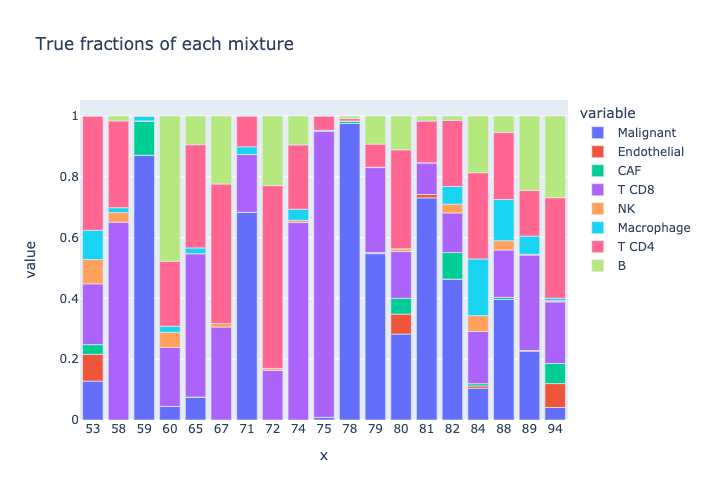

In [13]:
fig = px.bar(
    fractions_truth,  #.astype(index={"mixture_id": str}),
    x=fractions_truth.index.astype(str),
    y=fractions_truth.columns,
    title="True fractions of each mixture"
)

fig.show()

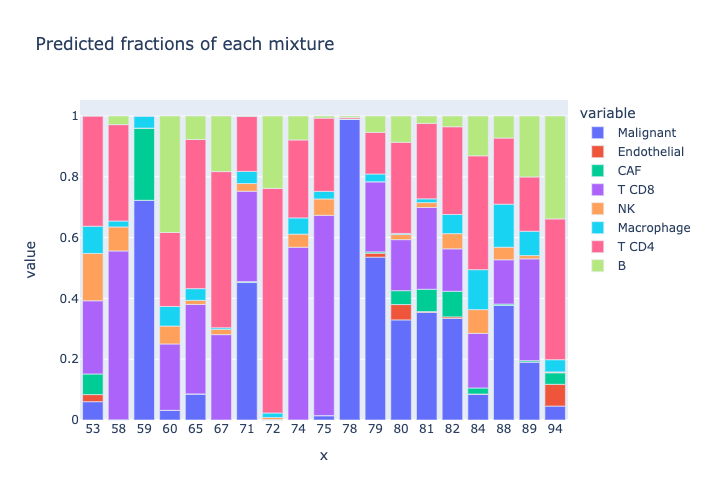

In [14]:
fig = px.bar(
    fractions_csx,  #.astype(index={"mixture_id": str}),
    x=fractions_csx.index.astype(str),
    y=fractions_csx.columns,
    title="Predicted fractions of each mixture"
)

fig.show()

In [15]:
signature_matrix = pd.read_csv(
    os.path.join(experiment_uri, 
                 "CIBERSORTx_screfsampletirosh_inferred_phenoclasses.CIBERSORTx_screfsampletirosh_inferred_refsample.bm.K999.txt"
#                  "CIBERSORTx_nferredphenoclassesdefaults.CIBERSORTx_nferredphenoclassesfromdefaults.bm.K999.txt"
                ),
    sep="\t",
    index_col=0
).rename_axis(index="gene").rename(columns=weird_to_nice)

signature_matrix

FileNotFoundError: 